In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
from scipy import ndimage
from astropy.stats import mad_std

In [3]:
path = '/vol/aibn1081/data1/brodriguez/'

## Opening CO(2-1) data cube for UGC12250

In [26]:
CO_cube = SpectralCube.read(path+'UGC12250_7m_co21_pbcor.fits')
CO_cube

SpectralCube with shape=(197, 120, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:   343.874350 deg:  343.925200 deg
 n_y:    120  type_y: DEC--SIN  unit_y: deg    range:    12.765276 deg:   12.814860 deg
 n_s:    197  type_s: VRAD      unit_s: m / s  range:  6617812.200 m / s: 7613756.253 m / s

## Extracting the minimal valid subcube

In [5]:
CO_cube = CO_cube.minimal_subcube()
if CO_cube.unit == 'Jy/beam':
    CO_cube = CO_cube.to(u.K)
if CO_cube.header['CUNIT3'] == 'm/s':
    CO_cube = CO_cube.with_spectral_unit(u.km/u.s)
CO_cube

SpectralCube with shape=(82, 72, 74) and unit=K:
 n_x:     74  type_x: RA---SIN  unit_x: deg    range:   343.884179 deg:  343.915372 deg
 n_y:     72  type_y: DEC--SIN  unit_y: deg    range:    12.776527 deg:   12.806110 deg
 n_s:     82  type_s: VRAD      unit_s: km / s  range:     6617.812 km / s:    7029.401 km / s

In [6]:
mom0 = CO_cube.moment(order=0)
mom1 = CO_cube.moment(order=1)
mom2 = CO_cube.moment(order=2)

/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


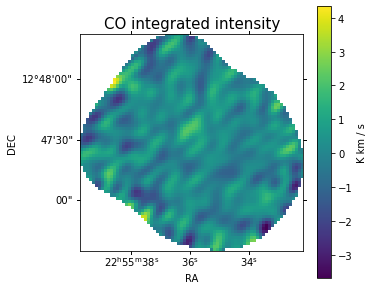

In [7]:
fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection':mom0.wcs})
im = ax.imshow(mom0.value,origin='lower')
fig.colorbar(im, ax=ax,label=mom0.unit)
ax.set_title('CO integrated intensity',fontsize=15)
ax.coords['ra'].set_axislabel('RA')
ax.coords['dec'].set_axislabel('DEC')
plt.show()

In [7]:
free_channels = 10 # number of emission-free channels ON EITHER SIDE of the cube
CO_RMS = np.concatenate((CO_cube.unmasked_data[:free_channels,:,:].value,CO_cube.unmasked_data[-free_channels:,:,:].value))
CO_RMS = np.sqrt(np.mean(np.square(CO_RMS),axis=0))
CO_std = np.concatenate((CO_cube.unmasked_data[:free_channels,:,:].value,CO_cube.unmasked_data[-free_channels:,:,:].value))
CO_std = np.std(CO_std,axis=0)
CO_madstd = np.concatenate((CO_cube.unmasked_data[:free_channels,:,:].value,CO_cube.unmasked_data[-free_channels:,:,:].value))
CO_madstd = mad_std(CO_madstd,axis=0)#,ignore_nan=True)

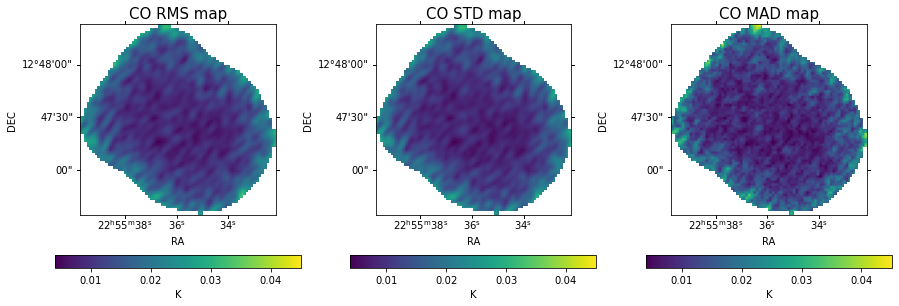

In [8]:
vmin = np.nanmin(CO_std)
vmax = np.nanmax(CO_madstd)
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,image,label in zip(axs.ravel(),[CO_RMS,CO_std,CO_madstd],['RMS','STD','MAD']):
    im = ax.imshow(image,origin='lower',vmin=vmin,vmax=vmax)
    fig.colorbar(im, ax=ax,orientation='horizontal',label=CO_cube.unit)
    ax.set_title('CO '+label+' map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Creating dilated mask

In [58]:
SNR_cube = CO_cube.unmasked_data[:].value
SNR_cube = SNR_cube/np.broadcast_to(CO_RMS,SNR_cube.shape)

In [59]:
high_SNR_mask = SNR_cube>4#3.5
low_SNR_mask = SNR_cube>2
labeled_mask_high, num_high = ndimage.label(high_SNR_mask)
print("Number of high SNR features found: ",num_high)
labeled_mask_low, num_low = ndimage.label(low_SNR_mask)
print("Number of low SNR features found: ",num_low)

Number of high SNR features found:  44
Number of low SNR features found:  1442


In [60]:
# ensuring high SNR regions span at least 2 adjacent channels
n = 0
m = 0
for i, region in enumerate(ndimage.find_objects(labeled_mask_high)):
    n+=1
    probe = np.where(labeled_mask_high[region]== i+1,high_SNR_mask[region],0)
    if (np.sum(probe,axis=0)<2).all():
        high_SNR_mask[labeled_mask_high==i+1]=0
    else:
        m+=1
print(n,m)

44 2


In [61]:
labeled_mask_high, num_high = ndimage.label(high_SNR_mask)
print("Number of high SNR features found: ",num_high)

Number of high SNR features found:  2
Number of low SNR features found:  1442


In [87]:
n = 0
m = 0
minarea = ((6)**2)*(2*np.pi)/(8*np.log(2))/(CO_pixscale**2)
for i, region in enumerate(ndimage.find_objects(labeled_mask_high)):
    n+=1
    probe = np.where(labeled_mask_high[region]== i+1,high_SNR_mask[region],0)
    if (np.count_nonzero(np.sum(probe,axis=0))<minarea):
        high_SNR_mask[labeled_mask_high==i+1]=0
    else:
        m+=1
print(n,m)

21 1


In [62]:
dilated_mask = np.isin(labeled_mask_low,labeled_mask_low[high_SNR_mask])

In [49]:
(CO_cube.unmasked_data[:].value[dilated_mask]<0).any()

False

In [ ]:
#### requiering minimum area equal to or larger than beam area for all features in the mask
#n = 0
#m = 0
#FWHM = 6 # FWHM in arcseconds
#minarea = ((FWHM)**2)*(2*np.pi)/(8*np.log(2))/(CO_pixscale**2)
#for i, region in enumerate(ndimage.find_objects(labeled_mask_dil)):
#    n+=1
#    probe = np.where(labeled_mask_dil[region]== i+1,dilated_mask[region],0)
#    if (np.count_nonzero(np.sum(probe,axis=0))<minarea):
#        dilated_mask[labeled_mask_dil==i+1]=0
#    else:
#        m+=1
#print(n,m)

In [63]:
dilated_mask = ndimage.binary_dilation(dilated_mask)
#dilated_mask = np.where(dilated_mask,dilated_mask,0.)

In [95]:
# requiring non-negative fluxes in unmasked pixels
dilated_mask = np.where((CO_cube.unmasked_data[:].value>=0)&np.isfinite(CO_cube.unmasked_data[:].value),dilated_mask,0)

In [54]:
(CO_cube.unmasked_data[:].value[dilated_mask]<0).any()

True

In [96]:
CO_cube_masked_dilated = CO_cube.with_mask(dilated_mask)

In [97]:
mom0_dilated = CO_cube_masked_dilated.moment(order=0)
mom1_dilated = CO_cube_masked_dilated.moment(order=1)
mom2_dilated = CO_cube_masked_dilated.moment(order=2)

/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


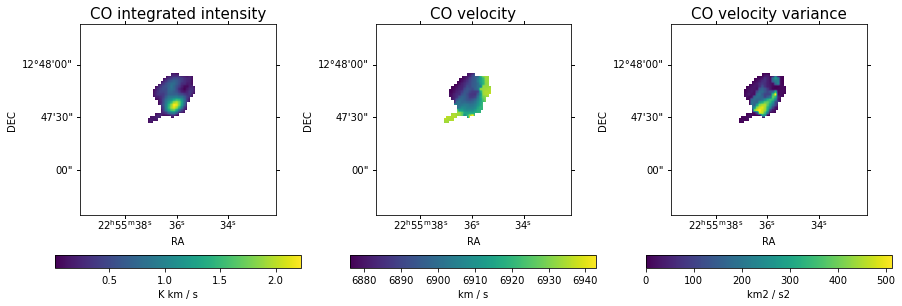

In [98]:
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,mommap,label in zip(axs.ravel(),[mom0_dilated,mom1_dilated,mom2_dilated],['integrated intensity','velocity','velocity variance']):
    im = ax.imshow(mommap.value,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=mommap.unit)
    ax.set_title('CO '+label,fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Creating smoothed mask

In [24]:
beam_orig = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)
beam_smooth9 = radio_beam.Beam(major=9*u.arcsec, minor=9*u.arcsec, pa=0*u.deg)
beam_smooth10 = radio_beam.Beam(major=10*u.arcsec, minor=10*u.arcsec, pa=0*u.deg)

In [25]:
CO_cube.beam

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [26]:
CO_cube_smooth = CO_cube.with_beam(beam_orig)
CO_cube_smooth = CO_cube_smooth.convolve_to(beam_smooth9)

In [24]:
CO_cube_smooth = CO_cube.convolve_to(beam_smooth10)

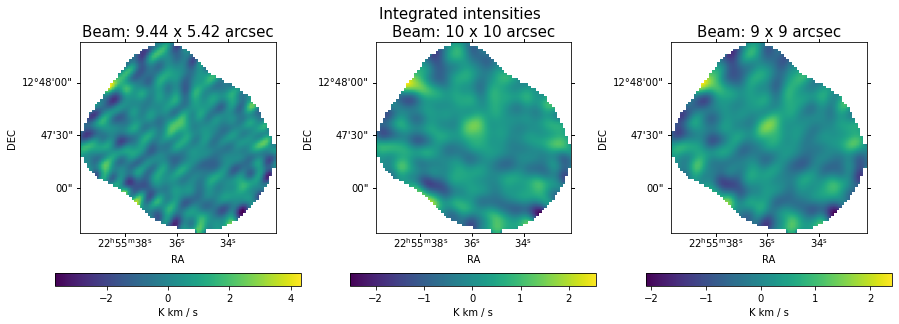

In [27]:
#vmin = np.nanmin(CO_std_smooth)
#vmax = np.nanmax(CO_madstd_smooth)
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,image,label in zip(axs.ravel(),[mom0,mom0_smooth10,mom0_smooth9],['9.44 x 5.42 arcsec','10 x 10 arcsec','9 x 9 arcsec']):
    im = ax.imshow(image.value,origin='lower')
    fig.colorbar(im, ax=ax,orientation='horizontal',label=image.unit)
    ax.set_title('Beam: '+label,fontsize=15)
    fig.suptitle('Integrated intensities',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

In [27]:
free_channels = 10
CO_RMS_smooth = np.concatenate((CO_cube_smooth.unmasked_data[:free_channels,:,:].value,CO_cube_smooth.unmasked_data[-free_channels:,:,:].value))
CO_RMS_smooth = np.sqrt(np.mean(np.square(CO_RMS_smooth),axis=0))
CO_std_smooth = np.concatenate((CO_cube_smooth.unmasked_data[:free_channels,:,:].value,CO_cube_smooth.unmasked_data[-free_channels:,:,:].value))
CO_std_smooth = np.std(CO_std_smooth,axis=0)
CO_madstd_smooth = np.concatenate((CO_cube_smooth.unmasked_data[:free_channels,:,:].value,CO_cube_smooth.unmasked_data[-free_channels:,:,:].value))
CO_madstd_smooth = mad_std(CO_madstd_smooth,axis=0)#,ignore_nan=True)

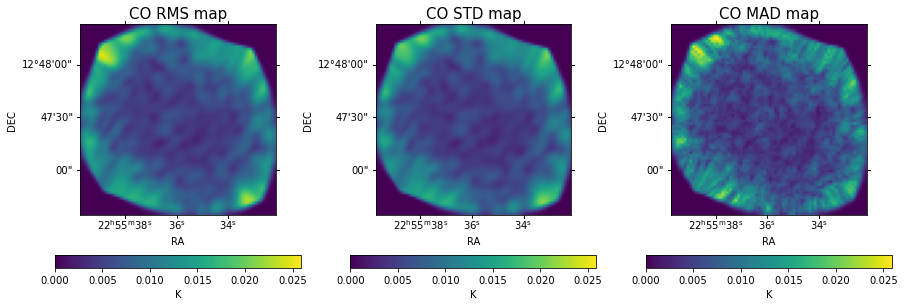

In [29]:
vmin = np.nanmin(CO_std_smooth)
vmax = np.nanmax(CO_madstd_smooth)
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,image,label in zip(axs.ravel(),[CO_RMS_smooth,CO_std_smooth,CO_madstd_smooth],['RMS','STD','MAD']):
    im = ax.imshow(image,origin='lower',vmin=vmin,vmax=vmax)
    fig.colorbar(im, ax=ax,orientation='horizontal',label=CO_cube.unit)
    ax.set_title('CO '+label+' map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

In [30]:
SNR_cube_smooth = CO_cube_smooth.unmasked_data[:].value
SNR_cube_smooth = SNR_cube_smooth/np.broadcast_to(CO_RMS_smooth,SNR_cube_smooth.shape)

In [31]:
high_SNR_mask_smooth = SNR_cube_smooth>4#3.5
low_SNR_mask_smooth = SNR_cube_smooth>2
labeled_mask_high_smooth, num_high = ndimage.label(high_SNR_mask_smooth)
print("Number of high SNR features found: ",num_high)
labeled_mask_low_smooth, num_low = ndimage.label(low_SNR_mask_smooth)
print("Number of low SNR features found: ",num_low)

Number of high SNR features found:  24
Number of low SNR features found:  860


In [32]:
n = 0
m = 0
for i, region in enumerate(ndimage.find_objects(labeled_mask_high_smooth)):
    n+=1
    probe = np.where(labeled_mask_high_smooth[region]== i+1,high_SNR_mask_smooth[region],0)
    if (np.sum(probe,axis=0)<2).all():
        high_SNR_mask_smooth[labeled_mask_high_smooth==i+1]=0
    else:
        m+=1
print(n,m)

24 1


In [33]:
labeled_mask_high_smooth, num_high = ndimage.label(high_SNR_mask_smooth)
print("Number of high SNR features found: ",num_high)

Number of high SNR features found:  1
Number of low SNR features found:  860


In [82]:
smooth_mask = np.isin(labeled_mask_low_smooth,labeled_mask_low_smooth[high_SNR_mask_smooth])

In [85]:
smooth_mask = ndimage.binary_dilation(smooth_mask,iterations=2)
#dilated_mask = np.where(dilated_mask,dilated_mask,0.)

In [87]:
# requiring non-negative fluxes in unmasked pixels
smooth_mask = np.where((CO_cube.unmasked_data[:].value>=0)&np.isfinite(CO_cube.unmasked_data[:].value),smooth_mask,0)

In [94]:
((CO_cube.unmasked_data[:].value)[smooth_mask]<0).any()

True

In [89]:
CO_cube_masked_smooth = CO_cube.with_mask(smooth_mask)

In [90]:
mom0_smooth = CO_cube_masked_smooth.moment(order=0)
mom1_smooth = CO_cube_masked_smooth.moment(order=1)
mom2_smooth = CO_cube_masked_smooth.moment(order=2)

/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/usr/lib/python3/dist-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


## Moment maps with smoothed mask

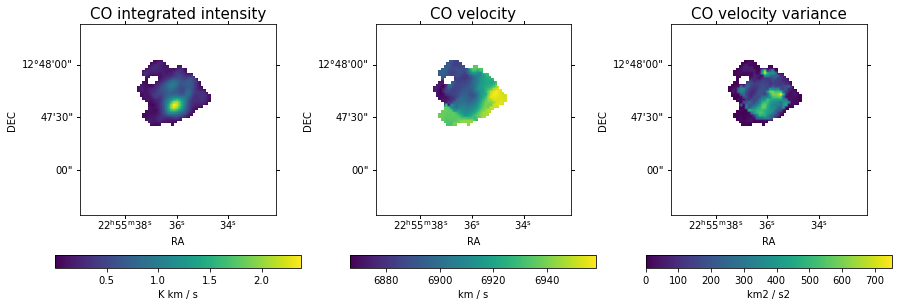

In [91]:
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,mommap,label in zip(axs.ravel(),[mom0_smooth,mom1_smooth,mom2_smooth],['integrated intensity','velocity','velocity variance']):
    im = ax.imshow(mommap.value,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=mommap.unit)
    ax.set_title('CO '+label,fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Moment maps with dilated mask

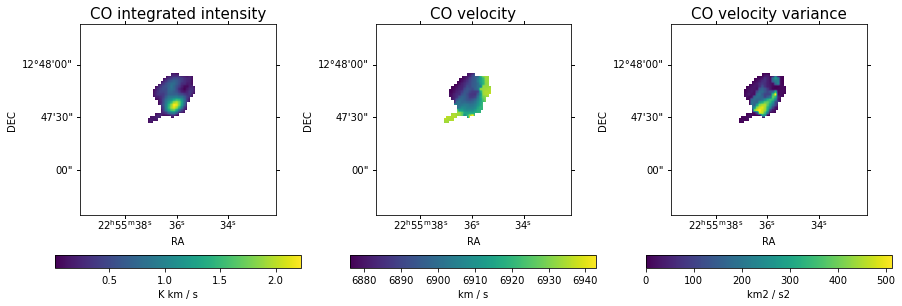

In [98]:
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,mommap,label in zip(axs.ravel(),[mom0_dilated,mom1_dilated,mom2_dilated],['integrated intensity','velocity','velocity variance']):
    im = ax.imshow(mommap.value,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=mommap.unit)
    ax.set_title('CO '+label,fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Moment maps with no mask

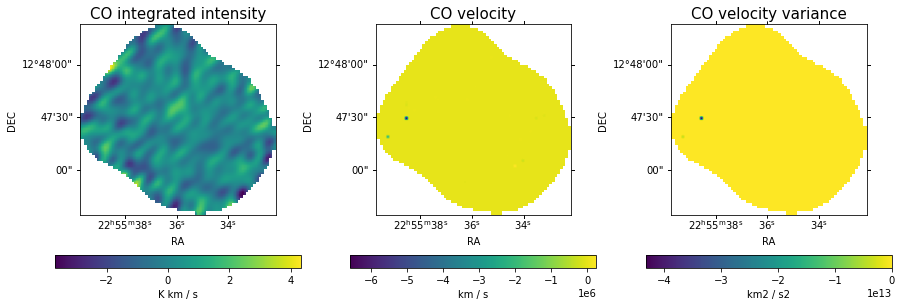

In [39]:
fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':mom0.wcs})
for ax,mommap,label in zip(axs.ravel(),[mom0,mom1,mom2],['integrated intensity','velocity','velocity variance']):
    im = ax.imshow(mommap.value,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=mommap.unit)
    ax.set_title('CO '+label,fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Opening Pipe3D output file for UGC12250

In [4]:
hdu_list = fits.open(path+'UGC12250.Pipe3D.cube.fits')

In [5]:
hdu_list.info()

Filename: /vol/aibn1081/data1/brodriguez/UGC12250.Pipe3D.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU     515   ()      
  1  SSP           1 ImageHDU       118   (160, 149, 21)   float64   
  2  SFH           1 ImageHDU      1608   (160, 149, 319)   float64   
  3  INDICES       1 ImageHDU        79   (160, 149, 70)   float64   
  4  ELINES        1 ImageHDU        68   (160, 149, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1310   (160, 149, 432)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      3134   (160, 149, 1040)   float64   
  7  GAIA_MASK     1 ImageHDU        10   (160, 149)   float64   
  8  SELECT_REG    1 ImageHDU        10   (160, 149)   int64   


In [134]:
# check header for emission line flux and flux error indices
#hdu_list[5].header

In [45]:
frames = [hdu_list[5].data[i] for i in [26,28,41,45,46,49,207,242,244,257,261,262,265,423]]
frames = np.array(frames)
frames[6] = -frames[6] # Ha emission line has negative EW, this makes it positive

In [7]:
region = hdu_list[8].data

In [9]:
# flux_OIII5007 -> 0, eflux_OIII5007 -> 7
# flux_Hbeta    -> 1, eflux_Hbeta    -> 8
# flux_OI6300   -> 2, eflux_OI6300   -> 9
# flux_Halpha   -> 3, eflux_Halpha   -> 10
# flux_NII6584  -> 4, eflux_NII6584  -> 11
# flux_SII6717  -> 5, eflux_SII6717  -> 12

# EW_Halpha     -> 6, eEW_Halpha     -> 13

# V_band  -> 14
# M_star  -> 15

In [46]:
for frame in frames:
    frame[region<1] = np.nan

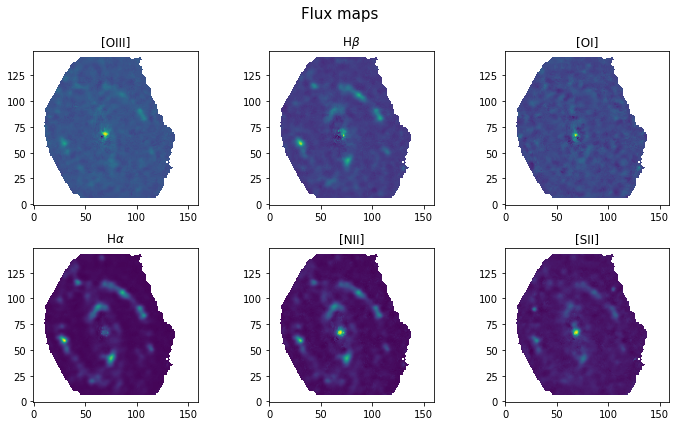

In [9]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,image,name in zip(axs.ravel(),frames[:6],['[OIII]',r'H$\beta$','[OI]',r'H$\alpha$','[NII]','[SII]']):
    ax.imshow(image,origin='lower')
    ax.set_title(name)
fig.suptitle('Flux maps',fontsize=15)
fig.tight_layout()
plt.show()

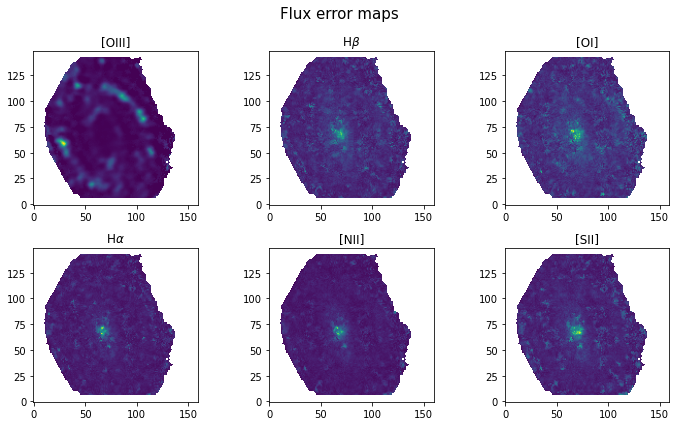

In [10]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,image,name in zip(axs.ravel(),frames[6:],['[OIII]',r'H$\beta$','[OI]',r'H$\alpha$','[NII]','[SII]']):
    ax.imshow(image,origin='lower')
    ax.set_title(name)
fig.suptitle('Flux error maps',fontsize=15)
fig.tight_layout()
plt.show()

/tmp/ipykernel_1934541/2668935537.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.imshow((flux/err)>1,origin='lower')


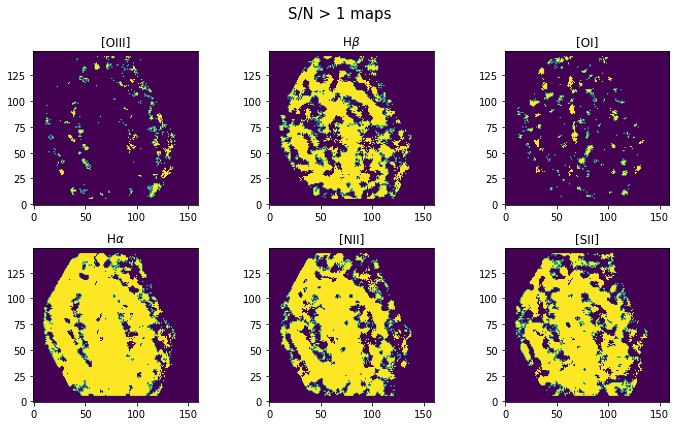

In [11]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,flux,err,name in zip(axs.ravel(),frames[:6],frames[6:],['[OIII]',r'H$\beta$','[OI]',r'H$\alpha$','[NII]','[SII]']):
    ax.imshow((flux/err)>1,origin='lower')
    ax.set_title(name)
fig.suptitle('S/N > 1 maps',fontsize=15)
fig.tight_layout()
plt.show()

In [113]:
Ha_EW = frames[6]

In [12]:
Ha_mask = (frames[6]/frames[13]>1)&(frames[6]>6)

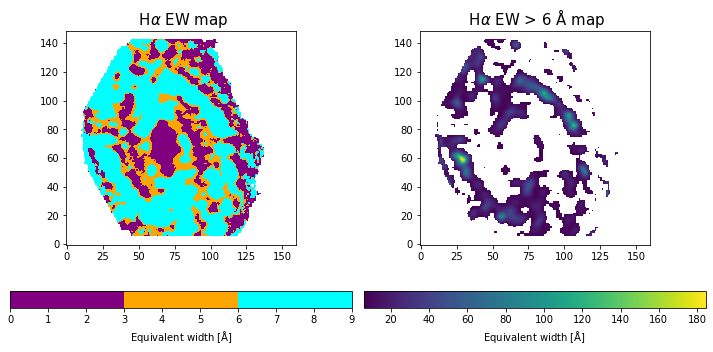

In [13]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
im = axs[0].imshow(frames[6], origin='lower',cmap=ListedColormap(['purple','orange','cyan']),vmin=0,vmax=9)
fig.colorbar(im,ax=axs[0],label='Equivalent width [$\mathrm{\AA}$]',orientation='horizontal')
axs[0].set_title(r' H$\alpha$ EW map',fontsize=15)
#im = axs[1].imshow(np.array(frames_cube[6].value), origin='lower')
im = axs[1].imshow(np.where(Ha_mask,frames[6],np.nan), origin='lower')
fig.colorbar(im,ax=axs[1],label='Equivalent width [$\mathrm{\AA}$]',orientation='horizontal')
axs[1].set_title(r' H$\alpha$ EW > 6 $\mathrm{\AA}$ map',fontsize=15)
fig.tight_layout()
plt.show()

# Smoothing and reprojecting CALIFA maps

In [14]:
wcs_califa = WCS(hdu_list[0].header).to_header()

In [15]:
wcs_califa['CRPIX3']=0
wcs_califa['CTYPE3']='VRAD'
wcs_califa['CUNIT3']='m/s'
#wcs_califa

In [79]:
#'''ONLY for masking with S/N>1'''
#for signal,noise in zip(frames[:7],frames[7:14]):
#    signal[signal/noise<=1] = np.nan

In [52]:
'''ONLY for masking with Ha EW S/N>1'''
for signal in frames[:7]:
    signal[~Ha_mask] = np.nan

In [38]:
#SN_mask = [signal/noise>1 for signal,noise in zip(frames[:7],frames[7:14])]*2
#SN_mask.append([signal/noise>1 for signal,noise in zip(frames[:6],frames[6:12])])
#SN_mask = SN_mask + [(frames[12]/frames[13])>1]*2
#SN_mask = np.array(SN_mask)
#SN_mask.shape

(14, 149, 160)

In [59]:
frames_cube = SpectralCube(data=frames[:7],wcs=WCS(wcs_califa))
frames_cube = frames_cube.with_mask(Ha_mask)
#frames_cube = frames_cube.with_mask(region)
#frames_cube = frames_cube.with_mask(frames[0]/frames[6]>1)
#frames_cube = frames_cube.with_mask(frames[:7]/frames[7:14]>1)

In [17]:
beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

In [18]:
beam_list = radio_beam.Beams(beams=[CO_cube.beam,beam_califa])
common_beam = radio_beam.commonbeam.common_2beams(beam_list)
#common_beam

NameError: name 'CO_cube' is not defined

In [60]:
frames_cube = frames_cube.with_beam(beam_califa)

In [61]:
frames_cube_convolved = frames_cube.convolve_to(beam_CO)

In [35]:
Halpha_0 = np.array(frames_cube_convolved[3,:,:])

In [58]:
Halpha_1 = np.array(frames_cube_convolved[3,:,:])

In [64]:
Halpha_2 = np.array(frames_cube_convolved[3,:,:])

In [27]:
target_header = CO_cube.header

In [28]:
target_header['NAXIS'] = 2
target_header['WCSAXES'] = 2
del target_header['NAXIS3'], target_header['CRPIX3'],target_header['CDELT3'],target_header['CUNIT3'],target_header['CTYPE3'],target_header['CRVAL3']

In [5]:
#target_header

In [62]:
reprojected_list = []
for frame in frames_cube_convolved:
    reprojected, footprint = reproject_exact((frame,WCS(wcs_califa).celestial),target_header)
    reprojected_list.append(reprojected)
reprojected_list = np.array(reprojected_list)

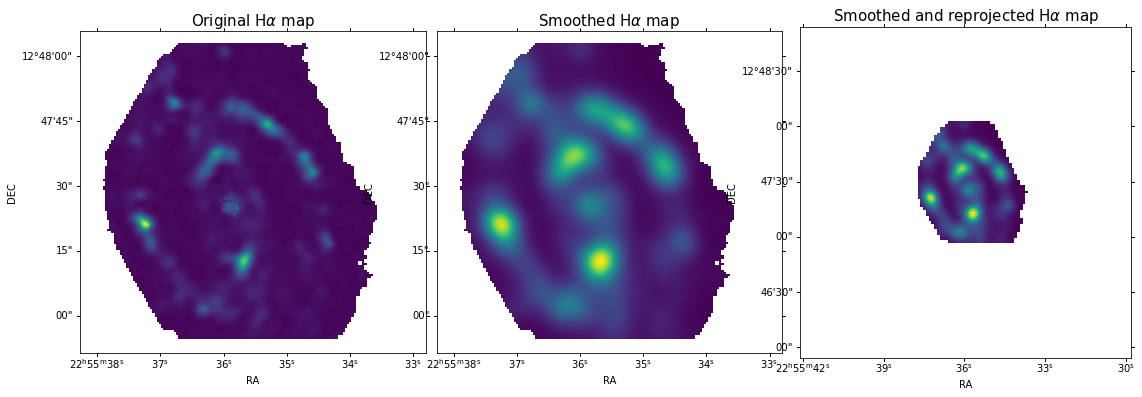

In [34]:
index = 3
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
for ax,frame,label in zip([ax1,ax2,ax3],[np.array(frames_cube[index,:,:]),np.array(frames_cube_convolved[index,:,:]),reprojected_list[index]],
                          ['Original','Smoothed','Smoothed and reprojected']):
    ax.imshow(frame, origin='lower')
    ax.set_title(label+r' H$\alpha$ map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
#ax.coords['dec'].set_axislabel_position('r')
#ax.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

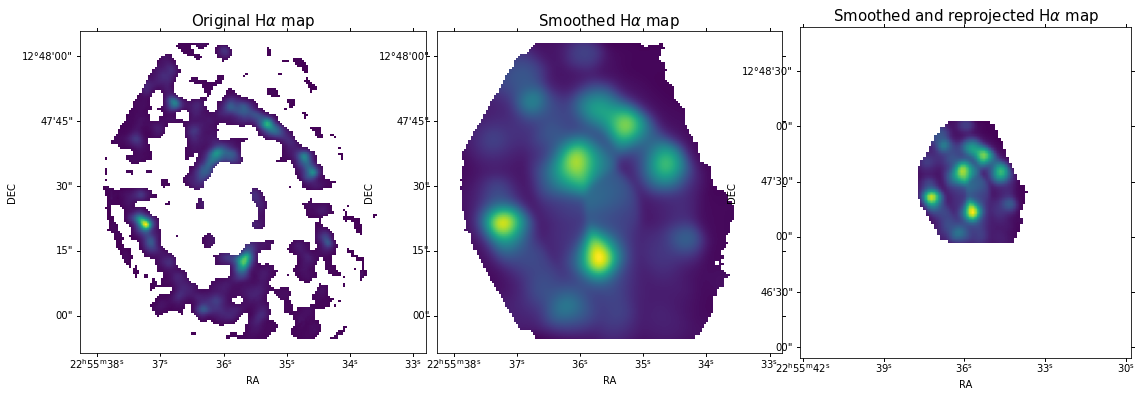

In [57]:
index = 3
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
for ax,frame,label in zip([ax1,ax2,ax3],[np.array(frames_cube[index,:,:]),np.array(frames_cube_convolved[index,:,:]),reprojected_list[index]],
                          ['Original','Smoothed','Smoothed and reprojected']):
    ax.imshow(frame, origin='lower')
    ax.set_title(label+r' H$\alpha$ map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
#ax.coords['dec'].set_axislabel_position('r')
#ax.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

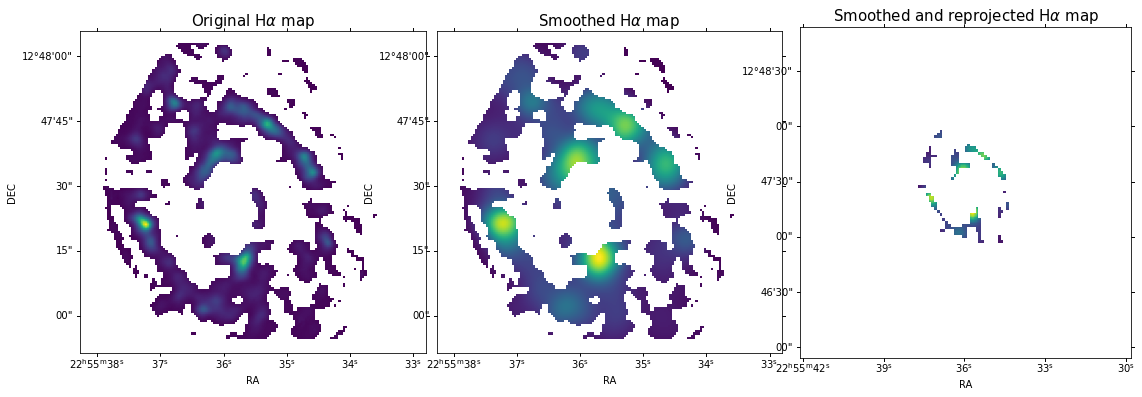

In [63]:
index = 3
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
for ax,frame,label in zip([ax1,ax2,ax3],[np.array(frames_cube[index,:,:]),np.array(frames_cube_convolved[index,:,:]),reprojected_list[index]],
                          ['Original','Smoothed','Smoothed and reprojected']):
    ax.imshow(frame, origin='lower')
    ax.set_title(label+r' H$\alpha$ map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
#ax.coords['dec'].set_axislabel_position('r')
#ax.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

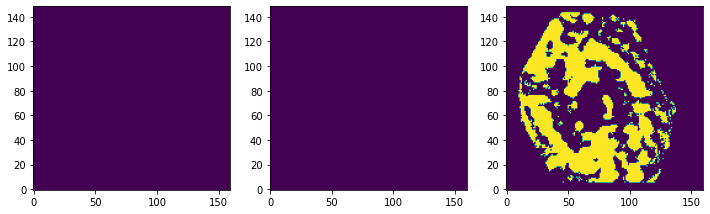

In [71]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(Halpha_0==Halpha_1,origin='lower')
ax[1].imshow(Halpha_0==Halpha_2,origin='lower')
ax[2].imshow(Halpha_1==Halpha_2,origin='lower')
plt.show()

# Line ratios

In [9]:
# flux_OIII5007 -> 0, eflux_OIII5007 -> 7
# flux_Hbeta    -> 1, eflux_Hbeta    -> 8
# flux_OI6300   -> 2, eflux_OI6300   -> 9
# flux_Halpha   -> 3, eflux_Halpha   -> 10
# flux_NII6584  -> 4, eflux_NII6584  -> 11
# flux_SII6717  -> 5, eflux_SII6717  -> 12

# EW_Halpha     -> 6, eEW_Halpha     -> 13

# V_band  -> 14
# M_star  -> 15

In [ ]:
# ((0.61/(NIIHa-0.47)+1.19)>OIIIHb)&(NIIHa<0.47)
# 1.01*NIIHa+0.48<OIIIHb

# 1.01*NIIHa+0.48 = 0.61/(NIIHa-0.47)+1.19
# 1.01*NIIHa+0.48 - 1.19 = 0.61/(NIIHa-0.47)

In [74]:
logratio_OIIIHb = np.log10(frames[0]/frames[1])
logratio_NIIHa  = np.log10(frames[4]/frames[3])
logratio_SIIHa  = np.log10(frames[5]/frames[3])
logratio_OIHa   = np.log10(frames[2]/frames[3])

/tmp/ipykernel_913127/1642796698.py:1: RuntimeWarning: invalid value encountered in log10
  logratio_OIIIHb = np.log10(frames[0]/frames[1])
/tmp/ipykernel_913127/1642796698.py:2: RuntimeWarning: invalid value encountered in log10
  logratio_NIIHa  = np.log10(frames[4]/frames[3])
/tmp/ipykernel_913127/1642796698.py:3: RuntimeWarning: invalid value encountered in log10
  logratio_SIIHa  = np.log10(frames[5]/frames[3])
/tmp/ipykernel_913127/1642796698.py:4: RuntimeWarning: invalid value encountered in log10
  logratio_OIHa   = np.log10(frames[2]/frames[3])


In [75]:
logratio_rpj_OIIIHb = np.log10(reprojected_list[0]/reprojected_list[1])
logratio_rpj_NIIHa  = np.log10(reprojected_list[4]/reprojected_list[3])
logratio_rpj_SIIHa  = np.log10(reprojected_list[5]/reprojected_list[3])
logratio_rpj_OIHa   = np.log10(reprojected_list[2]/reprojected_list[3])

/tmp/ipykernel_913127/539124499.py:4: RuntimeWarning: invalid value encountered in log10
  logratio_rpj_OIHa   = np.log10(reprojected_list[2]/reprojected_list[3])


In [76]:
maskSF_NII = ((0.61/(logratio_NIIHa-0.47)+1.19)>logratio_OIIIHb)&(logratio_NIIHa<0.47)
maskSy_NII = (((0.61/(logratio_NIIHa-0.47)+1.19)<=logratio_OIIIHb)|(logratio_NIIHa>=0.47))&(1.01*logratio_NIIHa+0.48<logratio_OIIIHb)
maskLI_NII = (((0.61/(logratio_NIIHa-0.47)+1.19)<=logratio_OIIIHb)|(logratio_NIIHa>=0.47))&(1.01*logratio_NIIHa+0.48>logratio_OIIIHb)
maskSF_SII = ((0.72/(logratio_SIIHa-0.32)+1.30)>logratio_OIIIHb)&(logratio_SIIHa<0.32)
maskSy_SII = (((0.72/(logratio_SIIHa-0.32)+1.30)<=logratio_OIIIHb)|(logratio_SIIHa>=0.32))&(1.89*logratio_SIIHa+0.76<logratio_OIIIHb)
maskLI_SII = (((0.72/(logratio_SIIHa-0.32)+1.30)<=logratio_OIIIHb)|(logratio_SIIHa>=0.32))&(1.89*logratio_SIIHa+0.76>logratio_OIIIHb)
maskSF_OI  = ((0.73/(logratio_OIHa +0.59)+1.33)>logratio_OIIIHb)&(logratio_OIHa<-0.59)
maskSy_OI  = (((0.73/(logratio_OIHa +0.59)+1.33)<=logratio_OIIIHb)|(logratio_OIHa>=-0.59))&(1.18*logratio_OIHa+1.3<logratio_OIIIHb)
maskLI_OI  = (((0.73/(logratio_OIHa +0.59)+1.33)<=logratio_OIIIHb)|(logratio_OIHa>=-0.59))&(1.18*logratio_OIHa+1.3>logratio_OIIIHb)

In [77]:
maskSF_rpj_NII = ((0.61/(logratio_rpj_NIIHa-0.47)+1.19)>logratio_rpj_OIIIHb)&(logratio_rpj_NIIHa<0.47)
maskSy_rpj_NII = (((0.61/(logratio_rpj_NIIHa-0.47)+1.19)<=logratio_rpj_OIIIHb)|(logratio_rpj_NIIHa>=0.47))&(1.01*logratio_rpj_NIIHa+0.48<logratio_rpj_OIIIHb)
maskLI_rpj_NII = (((0.61/(logratio_rpj_NIIHa-0.47)+1.19)<=logratio_rpj_OIIIHb)|(logratio_rpj_NIIHa>=0.47))&(1.01*logratio_rpj_NIIHa+0.48>logratio_rpj_OIIIHb)
maskSF_rpj_SII = ((0.72/(logratio_rpj_SIIHa-0.32)+1.30)>logratio_rpj_OIIIHb)&(logratio_rpj_SIIHa<0.32)
maskSy_rpj_SII = (((0.72/(logratio_rpj_SIIHa-0.32)+1.30)<=logratio_rpj_OIIIHb)|(logratio_rpj_SIIHa>=0.32))&(1.89*logratio_rpj_SIIHa+0.76<logratio_rpj_OIIIHb)
maskLI_rpj_SII = (((0.72/(logratio_rpj_SIIHa-0.32)+1.30)<=logratio_rpj_OIIIHb)|(logratio_rpj_SIIHa>=0.32))&(1.89*logratio_rpj_SIIHa+0.76>logratio_rpj_OIIIHb)
maskSF_rpj_OI  = ((0.73/(logratio_rpj_OIHa +0.59)+1.33)>logratio_rpj_OIIIHb)&(logratio_rpj_OIHa<-0.59)
maskSy_rpj_OI  = (((0.73/(logratio_rpj_OIHa +0.59)+1.33)<=logratio_rpj_OIIIHb)|(logratio_rpj_OIHa>=-0.59))&(1.18*logratio_rpj_OIHa+1.3<logratio_rpj_OIIIHb)
maskLI_rpj_OI  = (((0.73/(logratio_rpj_OIHa +0.59)+1.33)<=logratio_rpj_OIIIHb)|(logratio_rpj_OIHa>=-0.59))&(1.18*logratio_rpj_OIHa+1.3>logratio_rpj_OIIIHb)

In [78]:
map_NII = np.zeros(frames[0].shape)
map_NII[maskSF_NII] = 1.
map_NII[maskSy_NII] = 2.
map_NII[maskLI_NII] = 3.
map_SII = np.zeros(frames[0].shape)
map_SII[maskSF_SII] = 1.
map_SII[maskSy_SII] = 2.
map_SII[maskLI_SII] = 3.
map_OI = np.zeros(frames[0].shape)
map_OI[maskSF_OI] = 1.
map_OI[maskSy_OI] = 2.
map_OI[maskLI_OI] = 3.

In [79]:
map_rpj_NII = np.zeros(reprojected_list[0].shape)
map_rpj_NII[maskSF_rpj_NII] = 1.
map_rpj_NII[maskSy_rpj_NII] = 2.
map_rpj_NII[maskLI_rpj_NII] = 3.
map_rpj_SII = np.zeros(reprojected_list[0].shape)
map_rpj_SII[maskSF_rpj_SII] = 1.
map_rpj_SII[maskSy_rpj_SII] = 2.
map_rpj_SII[maskLI_rpj_SII] = 3.
map_rpj_OI = np.zeros(reprojected_list[0].shape)
map_rpj_OI[maskSF_rpj_OI] = 1.
map_rpj_OI[maskSy_rpj_OI] = 2.
map_rpj_OI[maskLI_rpj_OI] = 3.

In [64]:
xNII = [np.linspace(-2,0.25,100),np.linspace(-0.19935,0.25+0.5,10)]
yNII = [0.61/(xNII[0]-0.47) + 1.19,1.01*xNII[1]+0.48]
xSII = [np.linspace(-1.5,0.1,100),np.linspace(-0.31459,0.1+0.5,10)]
ySII = [0.72/(xSII[0]-0.32) + 1.3,1.89*xSII[1]+0.76]
xOI  = [np.linspace(-2.5,-0.8,100),np.linspace(-1.1269,-0.8+0.5,10)]
yOI  = [0.73/(xOI[0]+0.59) + 1.33,1.18*xOI[1]+1.3]

## Results without masking with S/N in the emission line fluxes:

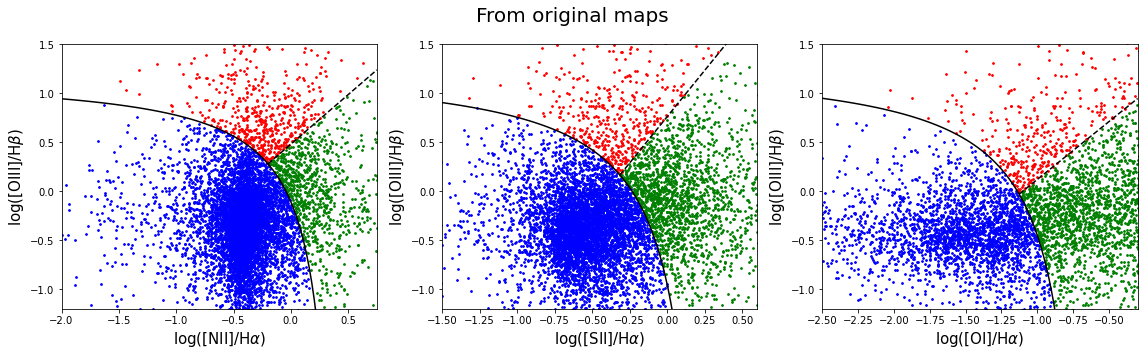

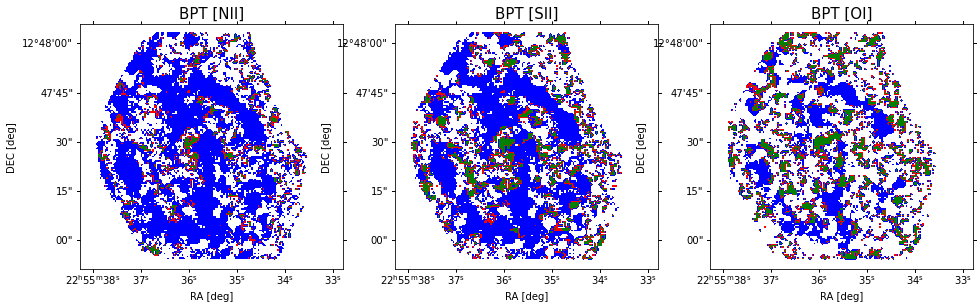

In [65]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_NIIHa,logratio_SIIHa,logratio_OIHa],
                             [maskSF_NII,maskSF_SII,maskSF_OI],[maskSy_NII,maskSy_SII,maskSy_OI],
                             [maskLI_NII,maskLI_SII,maskLI_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x[0],y[0],c='k')
    ax.plot(x[1],y[1],c='k',ls='--')
    ax.scatter(ratio[maskSF],logratio_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0][0],x[0][-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From original maps',fontsize=20)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_NII,map_SII,map_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

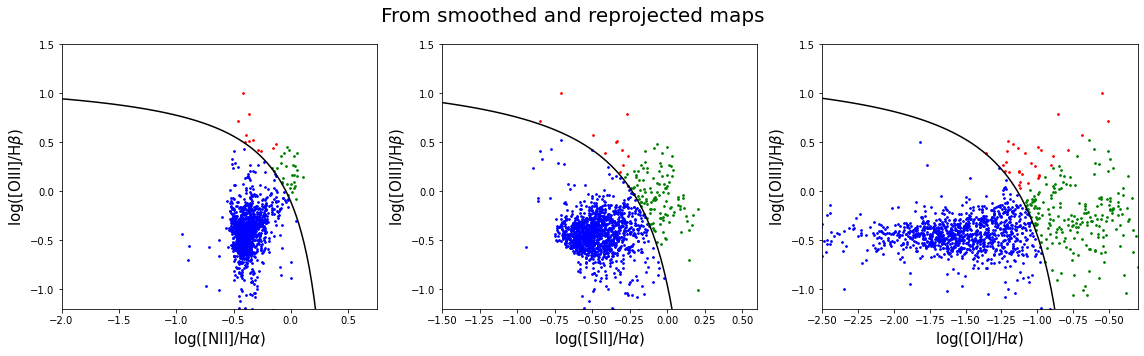

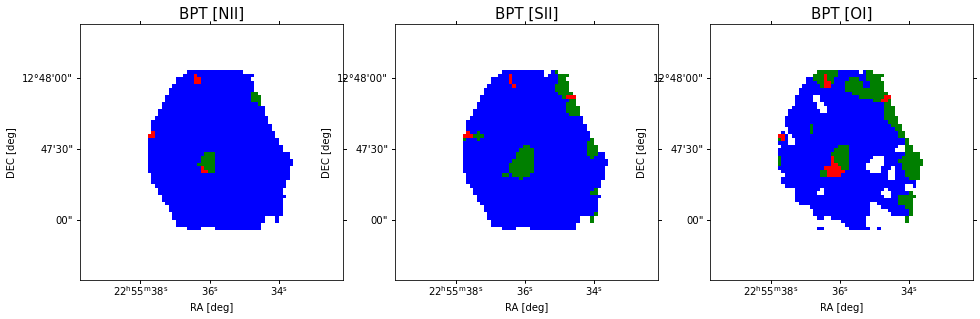

In [51]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_rpj_NIIHa,logratio_rpj_SIIHa,logratio_rpj_OIHa],
                             [maskSF_rpj_NII,maskSF_rpj_SII,maskSF_rpj_OI],[maskSy_rpj_NII,maskSy_rpj_SII,maskSy_rpj_OI],
                             [maskLI_rpj_NII,maskLI_rpj_SII,maskLI_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x[0],y[0],c='k')
    ax.plot(x[1],y[1],c='k',ls='--')
    ax.scatter(ratio[maskSF],logratio_rpj_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_rpj_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_rpj_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0][0],x[0][-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From smoothed and reprojected maps',fontsize=20)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(target_header)})
for ax,MAP,label in zip(axs2.ravel(),[map_rpj_NII,map_rpj_SII,map_rpj_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

## Results after masking with S/N>1 in the emission line fluxes:

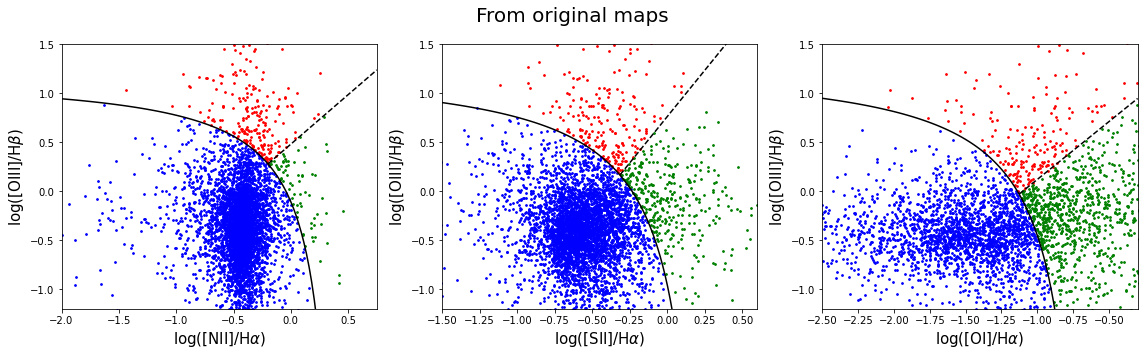

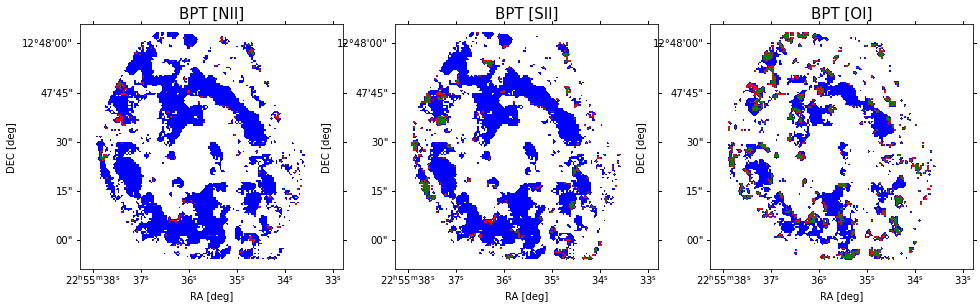

In [80]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_NIIHa,logratio_SIIHa,logratio_OIHa],
                             [maskSF_NII,maskSF_SII,maskSF_OI],[maskSy_NII,maskSy_SII,maskSy_OI],
                             [maskLI_NII,maskLI_SII,maskLI_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x[0],y[0],c='k')
    ax.plot(x[1],y[1],c='k',ls='--')
    ax.scatter(ratio[maskSF],logratio_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0][0],x[0][-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From original maps',fontsize=20)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_NII,map_SII,map_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

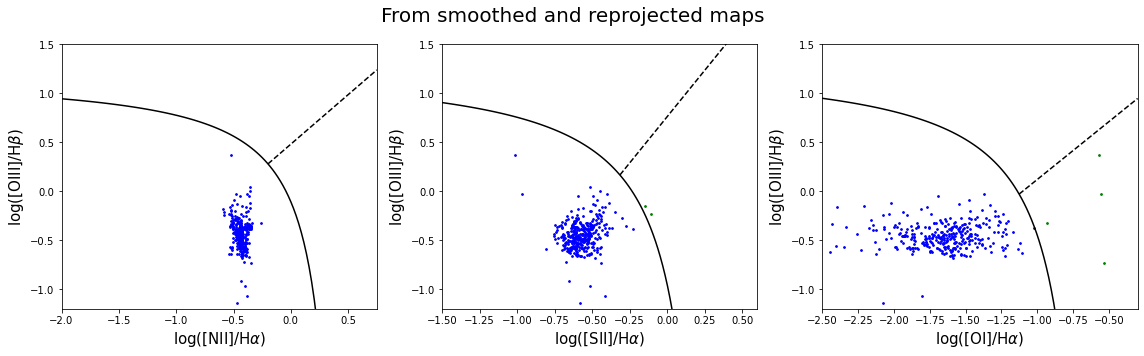

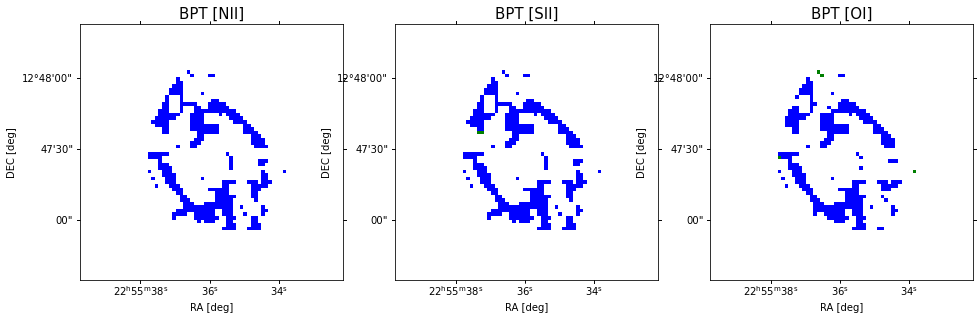

In [81]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_rpj_NIIHa,logratio_rpj_SIIHa,logratio_rpj_OIHa],
                             [maskSF_rpj_NII,maskSF_rpj_SII,maskSF_rpj_OI],[maskSy_rpj_NII,maskSy_rpj_SII,maskSy_rpj_OI],
                             [maskLI_rpj_NII,maskLI_rpj_SII,maskLI_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x[0],y[0],c='k')
    ax.plot(x[1],y[1],c='k',ls='--')
    ax.scatter(ratio[maskSF],logratio_rpj_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_rpj_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_rpj_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0][0],x[0][-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From smoothed and reprojected maps',fontsize=20)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(target_header)})
for ax,MAP,label in zip(axs2.ravel(),[map_rpj_NII,map_rpj_SII,map_rpj_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()

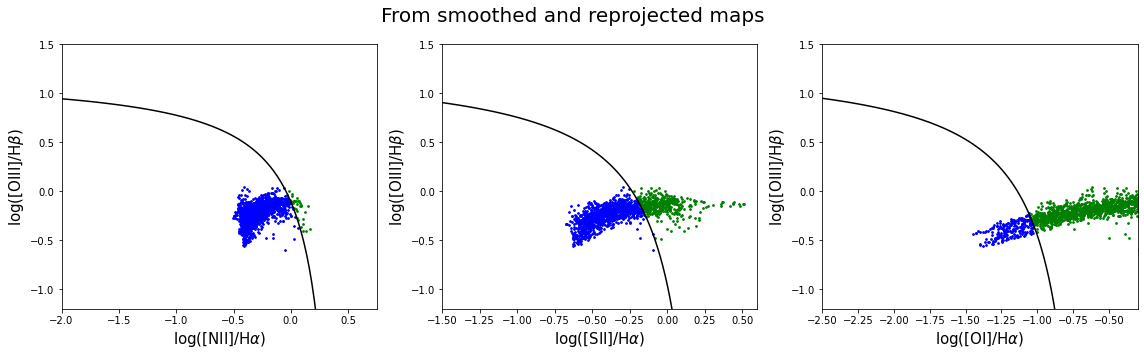

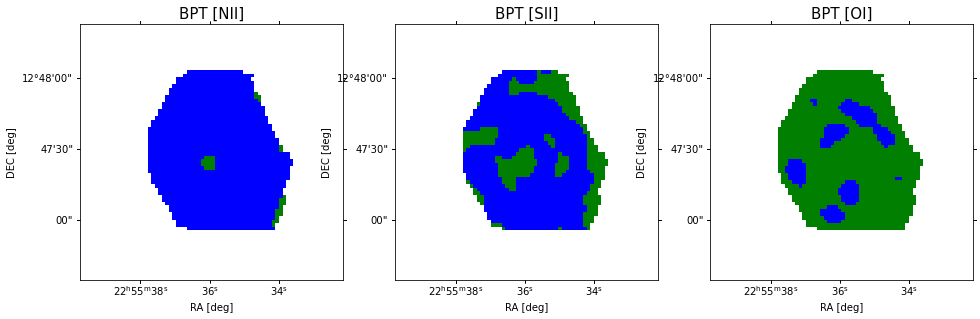

In [33]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_rpj_NIIHa,logratio_rpj_SIIHa,logratio_rpj_OIHa],
                             [maskSF_rpj_NII,maskSF_rpj_SII,maskSF_rpj_OI],[maskSy_rpj_NII,maskSy_rpj_SII,maskSy_rpj_OI],
                             [maskLI_rpj_NII,maskLI_rpj_SII,maskLI_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x[0],y[0],c='k')
    ax.plot(x[1],y[1],c='k',ls='--')
    ax.scatter(ratio[maskSF],logratio_rpj_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_rpj_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_rpj_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0][0],x[0][-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From smoothed and reprojected maps',fontsize=20)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(target_header)})
for ax,MAP,label in zip(axs2.ravel(),[map_rpj_NII,map_rpj_SII,map_rpj_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['dec'].set_axislabel('DEC')
plt.show()